<a href="https://colab.research.google.com/github/aliceliang0/GitPractice/blob/master/visionx1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [1]:
!nvidia-smi

Fri Aug 14 01:50:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [27]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/content/drive/My Drive/visiondata/data3_car/train"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

Found 520 images belonging to 5 classes.


In [28]:
from keras.preprocessing.image import ImageDataGenerator

val_DIR = "/content/drive/My Drive/visiondata/data3_car/val"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

val_datagen =  ImageDataGenerator(
      rescale=1./255
    )

val_generator = val_datagen.flow_from_directory(val_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                class_mode='categorical')

Found 88 images belonging to 5 classes.


In [29]:
#popping layers:By setting the layer.trainable=False
#we can add on our FC layers
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

# class_list = ["NO", "P1", "P2", "P3", "P4"]
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=5)

In [31]:
#Finetuning
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 30
BATCH_SIZE = 8
num_train_images = 520

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, validation_data=val_generator,
                                       validation_steps=88//BATCH_SIZE,callbacks=callbacks_list)




Epoch 1/30
65/65 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.4115
Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
65/65 [==============================] - 22s 340ms/step - loss: 1.3856 - accuracy: 0.4115 - val_loss: 1.0881 - val_accuracy: 0.8295
Epoch 2/30
65/65 [==============================] - ETA: 0s - loss: 1.2448 - accuracy: 0.4827
Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
65/65 [==============================] - 20s 310ms/step - loss: 1.2448 - accuracy: 0.4827 - val_loss: 0.9947 - val_accuracy: 0.6023
Epoch 3/30
65/65 [==============================] - ETA: 0s - loss: 1.2060 - accuracy: 0.5000
Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
65/65 [==============================] - 20s 310ms/step - loss: 1.2060 - accuracy: 0.5000 - val_loss: 0.9846 - val_accuracy: 0.8409
Epoch 4/30
65/65 [==============================] - ETA: 0s - loss: 1.1262 - accuracy: 0.5385
Epoch 00004: saving m

In [19]:

# Plot the training and validation loss + accuracy
# def plot_training(history):
#     acc = history.history['accuracy']
#     # val_acc = history.history['val_acccuracy']
#     loss = history.history['loss']
#     # val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, 'r.')
#     # plt.plot(epochs, val_acc, 'r')
#     plt.title('Training accuracy')

#     # plt.figure()
#     # plt.plot(epochs, loss, 'r.')
#     # plt.plot(epochs, val_loss, 'r-')
#     # plt.title('Training and validation loss')
#     plt.show()

#     plt.savefig('acc_vs_epochs.png')

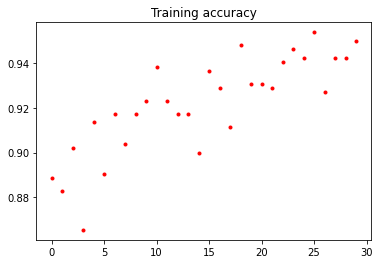

<Figure size 432x288 with 0 Axes>

In [20]:
# plot_training(history)

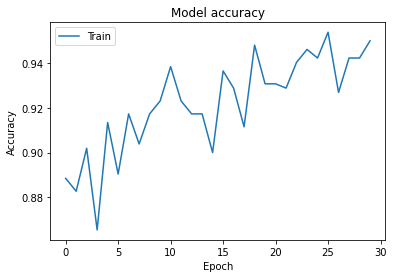

In [18]:
plt.figure()
plt.plot(history.history['accuracy']) 
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test']) 
plt.show()

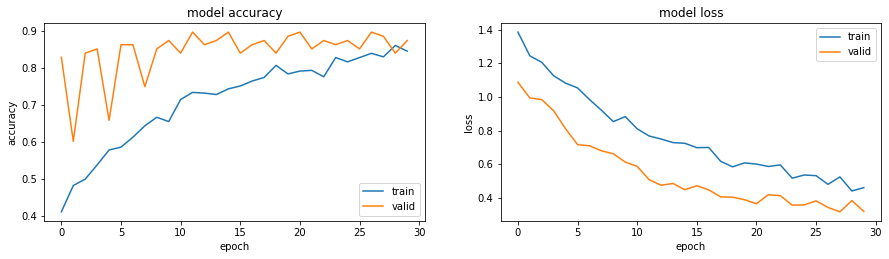

In [35]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()